## **Hamda Abuhadid**

###**Lab 2 - MBZUAI Fall 2025**


In [35]:

# Install packages
!pip install -q scikit-learn>=1.0 numpy>=1.21 pandas>=1.3 matplotlib>=3.4 jupyterlab ruff nbstripout

# To Create folders
import os
os.makedirs("ml_python/lab2/src", exist_ok=True)
os.makedirs("ml_python/lab2/notebooks/figures", exist_ok=True)


In [36]:
# Creating housing.py file to use
with open("ml_python/lab2/src/housing.py","w") as f:
    f.write('''import random
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np

BASE_PIPELINE = [
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
]

MODELS = {
    "simple_elastic": {
        "pipeline": Pipeline(BASE_PIPELINE + [("model", ElasticNet(max_iter=1000))]),
        "param_grid": {
            "model__alpha": [0.001,0.01,0.1,0.3,0.5,0.7,1.0,10.0],
            "model__l1_ratio": [0.0,0.5,1.0],
        },
    },
    "poly_elastic": {
        "pipeline": Pipeline(BASE_PIPELINE + [
            ("poly", PolynomialFeatures(degree=2, include_bias=False)),
            ("model", ElasticNet(max_iter=1000)),
        ]),
        "param_grid": {
            "model__alpha": [0.001,0.01,0.1,0.3,0.5,0.7,1.0,10.0],
            "model__l1_ratio": [0.0,0.5,1.0],
        },
    },
    "knn": {
        "pipeline": Pipeline(BASE_PIPELINE + [("model", KNeighborsRegressor())]),
        "param_grid": {
            "model__n_neighbors": [2,5,10,20,50],
            "model__p": [1,2],
        },
    },
}

def set_seed(seed:int=1):
    np.random.seed(seed)
    random.seed(seed)

def load_dataset(test_size:float=0.2, random_state:int=1):
    ds = fetch_california_housing(as_frame=True)
    df = ds.frame.copy()
    X = df.drop(columns=["MedHouseVal"])
    y = df["MedHouseVal"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

def train(model:str, X_train:pd.DataFrame, y_train:pd.DataFrame, cv_splits:int=5, random_state:int=1):
    pipeline = MODELS[model]["pipeline"]
    param_grid = MODELS[model]["param_grid"]
    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    gs = GridSearchCV(pipeline, param_grid, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1, refit=True)
    gs.fit(X_train, y_train)
    return gs

def eval(gs:GridSearchCV, X_test:pd.DataFrame, y_test:pd.DataFrame):
    best = gs.best_estimator_
    y_pred = best.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return {"estimator": best["model"], "preds": y_pred, "rmse": rmse, "mae": mae, "r2": r2}
''')
print("housing.py created!")

housing.py created!


In [37]:

# Set up imports and make sure housing.py is accessible
# Set seed
import sys
sys.path.append("ml_python/lab2/src")

import matplotlib.pyplot as plt
from housing import train, eval, load_dataset, set_seed

SEED = 1
set_seed(SEED)


In [38]:
# Load dataset
X_train, X_test, y_train, y_test = load_dataset(test_size=0.2, random_state=SEED)


In [39]:
# Plots for each model
# shows residuals and predicted vs actual values

def plot_results(model_name, results):
    out_dir = "ml_python/lab2/notebooks/figures"
    os.makedirs(out_dir, exist_ok=True)

    plt.figure()
    plt.hist(y_test - results["preds"], bins=40)
    plt.title(f"{model_name} Residuals")
    plt.xlabel("Residual")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{model_name}_residuals.png"))
    plt.show()

    plt.figure()
    plt.scatter(y_test, results["preds"], s=6)
    plt.title(f"{model_name} Predicted vs True")
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{model_name}_pred_vs_true.png"))
    plt.show()


### Simple Linear Regression

Simple ElasticNet:
Best alpha: 0.01
Best L1 ratio: 1.0
RMSE: 0.73
MAE: 0.54
R2: 0.59


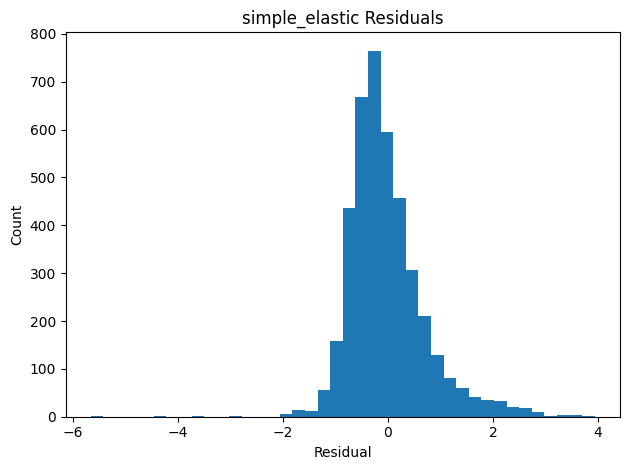

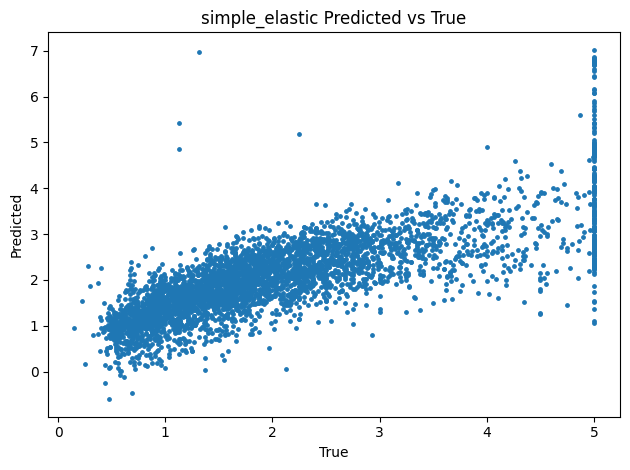

In [40]:

fitted_gs = train("simple_elastic", X_train, y_train, random_state=SEED)
results = eval(fitted_gs, X_test, y_test)

print("Simple ElasticNet:")
print(f"Best alpha: {results['estimator'].alpha}")
print(f"Best L1 ratio: {results['estimator'].l1_ratio}")
print(f"RMSE: {results['rmse']:.2f}")
print(f"MAE: {results['mae']:.2f}")
print(f"R2: {results['r2']:.2f}")

plot_results("simple_elastic", results)


### Polynomial Regression

Polynomial ElasticNet:
Best alpha: 0.1
Best L1 ratio: 1.0
RMSE: 0.81
MAE: 0.61
R2: 0.50


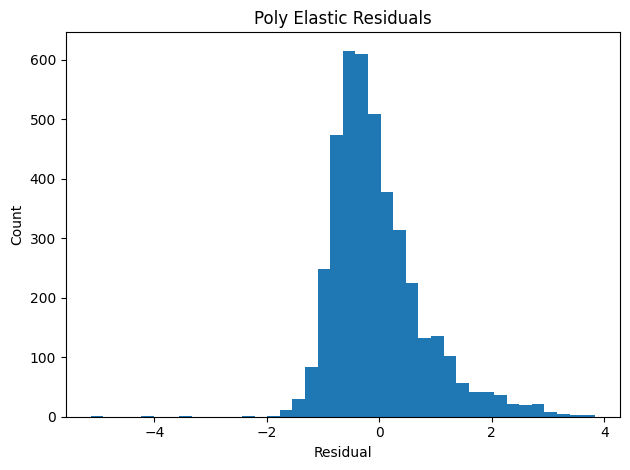

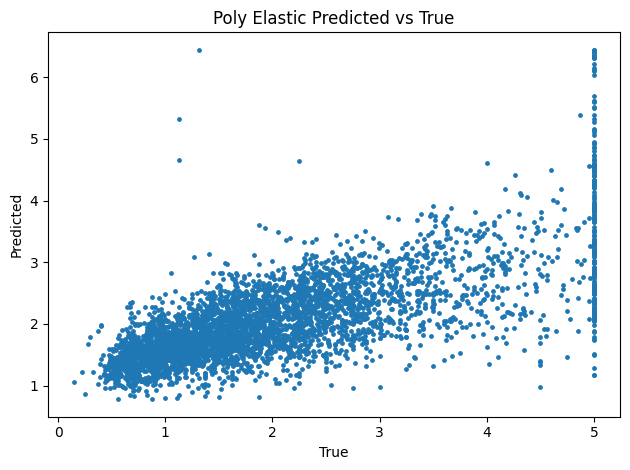

In [41]:

fitted_gs = train("poly_elastic", X_train, y_train, random_state=SEED)
results = eval(fitted_gs, X_test, y_test)

print("Polynomial ElasticNet:")
print(f"Best alpha: {results['estimator'].alpha}")
print(f"Best L1 ratio: {results['estimator'].l1_ratio}")
print(f"RMSE: {results['rmse']:.2f}")
print(f"MAE: {results['mae']:.2f}")
print(f"R2: {results['r2']:.2f}")

plot_results("Poly Elastic", results)


### kNN Regression

KNN:
Best n_neighbors: 10
Best metric p: 1
RMSE: 0.60
MAE: 0.41
R2: 0.73


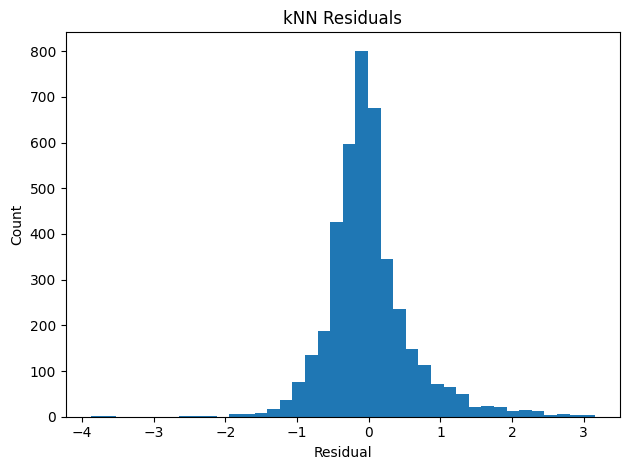

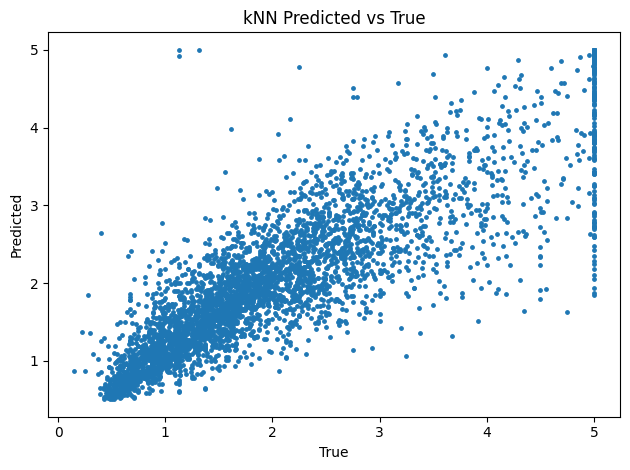

In [42]:

fitted_gs = train("knn", X_train, y_train, random_state=SEED)
results = eval(fitted_gs, X_test, y_test)

print("KNN:")
print(f"Best n_neighbors: {results['estimator'].n_neighbors}")
print(f"Best metric p: {results['estimator'].p}")
print(f"RMSE: {results['rmse']:.2f}")
print(f"MAE: {results['mae']:.2f}")
print(f"R2: {results['r2']:.2f}")

plot_results("kNN", results)
